<a href="https://colab.research.google.com/github/fares22-dev/Kaggle/blob/main/Backpack_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.3.1
Uninstalling scikit-learn-1.3.1:
  Successfully uninstalled scikit-learn-1.3.1
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/playground-series-s5e2.zip -d /content/dataset

Archive:  /content/drive/MyDrive/playground-series-s5e2.zip
replace /content/dataset/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('/content/dataset/train.csv',index_col="id")
test_data = pd.read_csv('/content/dataset/test.csv', index_col="id")

In [ ]:
train_data.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [ ]:
test_data.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
id,,,,,,,,,
300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


BASIC FEATURE ENGINEERING

In [ ]:
print(train_data.shape)
for col in train_data.columns:
    nan_count = train_data[col].isna().sum()
    print(f"Column '{col}' has {nan_count} NaN values")


(300000, 10)
Column 'Brand' has 0 NaN values
Column 'Material' has 0 NaN values
Column 'Size' has 0 NaN values
Column 'Compartments' has 0 NaN values
Column 'Laptop Compartment' has 0 NaN values
Column 'Waterproof' has 0 NaN values
Column 'Style' has 0 NaN values
Column 'Color' has 0 NaN values
Column 'Weight Capacity (kg)' has 0 NaN values
Column 'Price' has 0 NaN values


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

le = LabelEncoder()
imputer = SimpleImputer(strategy="most_frequent")  # Impute with most frequent value

def encode(data):
    data = data.copy()  # Avoid modifying the original DataFrame
    data[:] = imputer.fit_transform(data)  # Impute missing values

    data["Brand"] = le.fit_transform(data["Brand"])
    data["Material"] = le.fit_transform(data["Material"])

    size_mapping = {'Small': 0, 'Medium': 1, 'Large': 2}
    data["Size"] = data["Size"].map(size_mapping)

    data["Laptop Compartment"] = le.fit_transform(data["Laptop Compartment"])
    data["Waterproof"] = le.fit_transform(data["Waterproof"])
    data["Style"] = le.fit_transform(data["Style"])
    data["Color"] = le.fit_transform(data["Color"])

    return data


In [ ]:
train_data=encode(train_data)
test_data=encode(test_data)

EXPLORATORY DATA ANALYSIS

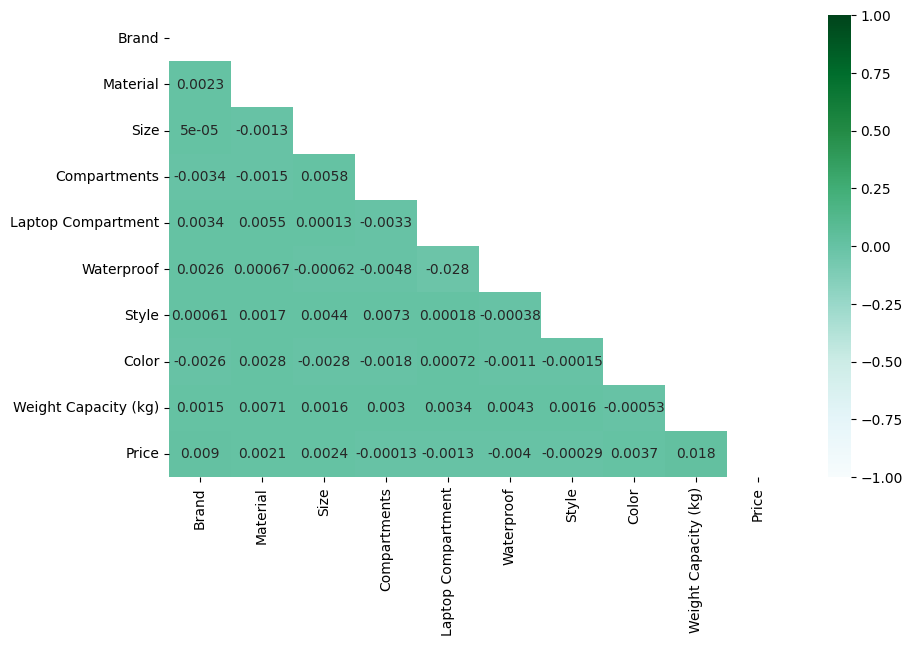

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
mask = np.triu(np.ones_like(train_data.corr()))
plt.figure(figsize=(10,6))
sns.heatmap(train_data.corr(), cmap="BuGn", annot=True, mask=mask,vmin=-1,vmax=1);

TRAINING MODELS

In [ ]:
seed = np.random.seed(6)

X = train_data.drop(["Price"],axis=1)
y = train_data["Price"]

In [ ]:
print(y.isna().sum())

0


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

lgbmmodel = LGBMRegressor(random_state=seed, device="cpu")

cv_score = cross_val_score(lgbmmodel, X, y, cv=4, scoring='neg_root_mean_squared_error')
rmse_score = -cv_score.mean()

print("CV RMSE score of LGBM is", rmse_score)


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 185014, number of used features: 9
[LightGBM] [Info] Start training from score 81.639383
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 185014, number of used features: 9
[LightGBM] [Info] Start training from score 81.547873
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=seed)
cv_score = cross_val_score(xgb_model,X,y,cv=4, scoring='neg_root_mean_squared_error')

rmse_score = -cv_score.mean()
print("CV RMSE score of XGBoost is", rmse_score)


CV RMSE score of XGBoost is 39.14905114074868


OPTUNA FINETUNING

In [ ]:
import optuna
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators',500,1000),
        "max_depth":trial.suggest_int('max_depth',3,50),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True),
        "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
        "min_child_samples" : trial.suggest_int('min_child_samples',1,250),
        "subsample" : trial.suggest_float('subsample', 0.2, 1),
        "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 128),
    }
    lgbmmodel_optuna = LGBMRegressor(**params,random_state=seed,device="cpu")
    cv_score = cross_val_score(lgbmmodel_optuna, X, y, cv=4, scoring='neg_root_mean_squared_error')
    rmse_score = -cv_score.mean()
    return rmse_score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10,timeout=2000)
print("Best hyperparameters:", study.best_params)
print("Best RMSE score:", study.best_value)
best_lgbm = LGBMRegressor(**study.best_params, random_state=seed, device="cpu")


In [ ]:
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators',500,750),
        'max_depth':  trial.suggest_int('max_depth',3,50),
        'min_child_weight': trial.suggest_float('min_child_weight', 2,50),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.2,log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1),
        'gamma': trial.suggest_float("gamma", 1e-4, 1.0),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        "colsample_bylevel" : trial.suggest_float('colsample_bylevel',0.2,1),
        "colsample_bynode" : trial.suggest_float('colsample_bynode',0.2,1),
    }
    xgbmodel_optuna = XGBRegressor(**params, random_state=seed, eval_metric="rmse")
    cv_score = cross_val_score(xgbmodel_optuna, X, y, cv=4, scoring='neg_root_mean_squared_error')
    rmse_score = -cv_score.mean()
    return rmse_score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=5000)


In [ ]:
best_lgbm.fit(X,y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 300000, number of used features: 9
[LightGBM] [Info] Start training from score 81.411107


LGBMRegressor(colsample_bytree=0.8376091221612045, device='cpu',
              learning_rate=0.1952937025659286, max_depth=18,
              min_child_samples=51, min_child_weight=2.738926768380949,
              n_estimators=775, num_leaves=109, subsample=0.9330953319763919,
              subsample_freq=4)

In [ ]:
xgb_model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
print(test_data.shape)

(200000, 9)


In [ ]:
submission = pd.DataFrame()
submission["id"] = test_data.index
submission["Price"] =(xgb_model.predict(test_data) + best_lgbm.predict(test_data))/2
submission.to_csv("submission_avg.csv",index=False)